<a href="https://colab.research.google.com/github/yukiao/Pengantar-Deep-Learning/blob/main/Week5/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !pip install d2l

# Configuration

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from datetime import  datetime
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
NUM_EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Architecture

In [23]:
class Inception(nn.Module):
  # `c1`--`c4` are the number of output channels for each path
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # Path 1 is a single 1 x 1 convolutional layer
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
    # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
    # convolutional layer
    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
    # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
    # convolutional layer
    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
    # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
    # convolutional layer
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    # Concatenate the outputs on the channel dimension
    return torch.cat((p1, p2, p3, p4), dim=1)

In [24]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [25]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [26]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [27]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [28]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

# Helpers

In [29]:
# Get accuracy on training
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [30]:
def plot_train(train_losses, train_accuracies):
  train_losses = torch.tensor(train_losses, device='cpu')
  train_accuracies = torch.tensor(train_accuracies, device='cpu')

  train_losses = train_losses.numpy()
  train_accuracies = train_accuracies.numpy()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

  ax[0].plot(train_losses, color="red", label="Training Loss")
  ax[0].set(title="Training Loss over epochs", xlabel="Epoch", ylabel="Loss")
  ax[0].legend()

  ax[1].plot(train_accuracies, color="blue", label="Training Accuracy")
  ax[1].set(title="Training Accuracy over epochs", xlabel="Epoch", ylabel="Accuracy")
  ax[1].legend()

  fig.show()

In [31]:
def train(model, train_loader, criterion, optimizer, device):
  model.train()

  for X, y_true in train_loader:
    optimizer.zero_grad()
    running_loss = 0

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass
    y_hat = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward pass
    loss.backward()
    optimizer.step()
  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [32]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    print("Start Training")
    print(f"Using {device} device")
    # Train model

    train_losses = []
    train_accuracies = []

    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accuracies.append(train_acc)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Loss: {train_loss:.4f}\t'
                  f'Accuracy: {100 * train_acc:.2f}%\t')
    plot_train(train_losses, train_accuracies)
    print("Finish")
    return model, optimizer

In [33]:
def imshow(img, title, index):
  plt.subplot(1,5,index)
  plt.axis('off')
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = np.clip(npimg, 0,1)
  plt.title(title)
  plt.imshow(img.reshape((96, 96)), cmap='gray')

# Training

In [34]:
train_dataset = datasets.MNIST("./data",
                                 train=True,
                                 transform = transforms.Compose([
                                    transforms.Resize((96, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                 ]),
                                 download = True)

test_dataset = datasets.MNIST("./data",
                                 train = False,
                                 transform = transforms.Compose([
                                    transforms.Resize((96, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1325,), (0.3105,))
                                 ]),
                                 download = True)

In [35]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [36]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [37]:
torch.manual_seed(RANDOM_SEED)
model = net.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Start Training
Using cuda device
11:00:06 --- Epoch: 0	Loss: 0.0037	Accuracy: 16.47%	
11:04:36 --- Epoch: 1	Loss: 0.0001	Accuracy: 93.62%	
11:09:06 --- Epoch: 2	Loss: 0.0003	Accuracy: 96.20%	
11:13:36 --- Epoch: 3	Loss: 0.0000	Accuracy: 98.00%	
11:18:06 --- Epoch: 4	Loss: 0.0001	Accuracy: 97.99%	
11:22:37 --- Epoch: 5	Loss: 0.0002	Accuracy: 98.03%	
11:27:07 --- Epoch: 6	Loss: 0.0001	Accuracy: 98.92%	
11:31:37 --- Epoch: 7	Loss: 0.0001	Accuracy: 98.45%	
11:36:07 --- Epoch: 8	Loss: 0.0000	Accuracy: 98.36%	
11:40:37 --- Epoch: 9	Loss: 0.0000	Accuracy: 99.29%	
Finish


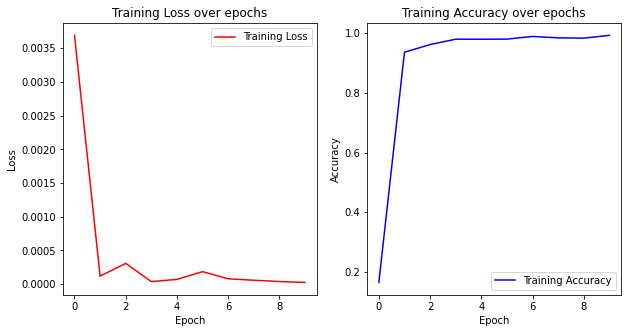

In [38]:
model, optimizer = training_loop(model, criterion, optimizer, train_loader, NUM_EPOCHS, device)

# Testing

In [39]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [40]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {format(100 * correct / total)} %')

Accuracy of the network on the 10000 test images: 98.87 %


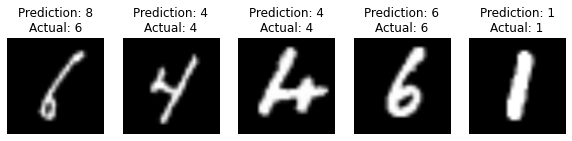

In [41]:
from torch.nn.modules.container import ModuleList
import torchvision
inputs, classes = next(iter(test_loader))
original_inputs = inputs
original_classes = classes

inputs = inputs.to(device)
classes = classes.to(device)

correct = 0

fig = plt.figure(figsize=(10,10))
for i in range(5):
  with torch.no_grad():
    model.eval()
    output = model(inputs[i].reshape(1,1,96, 96))
    out = output.cpu().data.numpy().argmax()
    predicted = out.item()
    correct = out == classes[i].item()
    imshow(original_inputs[i], f"Prediction: {predicted}\nActual: {classes[i].item()}", i+1)

plt.show()